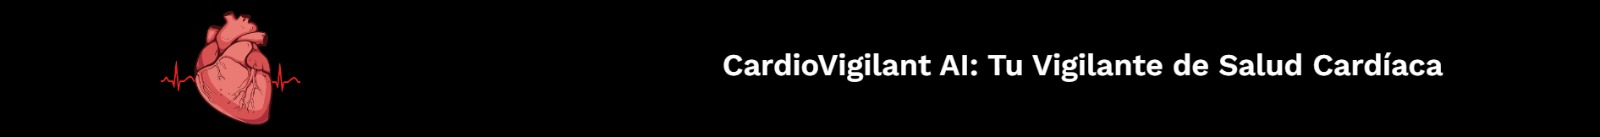

#ExpoTecnológica - Hackaton Grupo 12

*   Karen Agudelo García
*   Gleydis Correal de los Rios
*   Roberto Echeverry Ríos
*   Jose Alexander Ríos
*   Andrés Orozco Duque



#Clasificación de señales ECG para detectar fibrilación ventricular


In [1]:
import numpy as np
import pylab as plt
from scipy import signal
from scipy.fft import fft, ifft
from scipy.signal import welch
import scipy.io as sio

In [2]:
! git clone https://github.com/Orozco-Duque/biosignals.git

Cloning into 'biosignals'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 32 (delta 7), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (32/32), 25.18 MiB | 6.56 MiB/s, done.
Resolving deltas: 100% (7/7), done.


Vamos a cargar una matriz de señales. En total se tienen 60 señales, 30 de ritmo sinusal y 30 con fibrilación ventricular.

In [3]:
ECG=sio.loadmat('/content/biosignals/Dbvt.mat')['DBvt']
fm=128
labelsECG=sio.loadmat('/content/biosignals/Cdbvt.mat')['Cdbvt']


La caracterización en la frecuencia se basa en el análisis del espectro de frecuencia.

Utilizando esta caracterización se pueden obtener variables que ayuden a discriminar las señales de fibrilación ventricular.

In [4]:
from scipy.signal import butter, filtfilt, lfilter
from scipy.signal import freqs
from scipy.signal import argrelextrema


Diseñamos un filtro pasabanda entre 1 y 50Hz

In [5]:
fs=128
fnq=fs/2
b, a = butter(2, [1/fnq,50/fnq], btype='bandpass')
print(b)
print(a)

[ 0.59020739  0.         -1.18041477  0.          0.59020739]
[ 1.         -0.86743287 -0.73791034  0.25507805  0.35605734]


Aplicamos el filtro a una señal

In [6]:
ecg1 = filtfilt(b, a, ECG[1,:].flatten())
ecg2 = filtfilt(b, a, ECG[31,:].flatten())

Para gráficar la señal se debe crear un vector de tiempo:

Text(0.5, 1.0, 'Fibrilación ventricular')

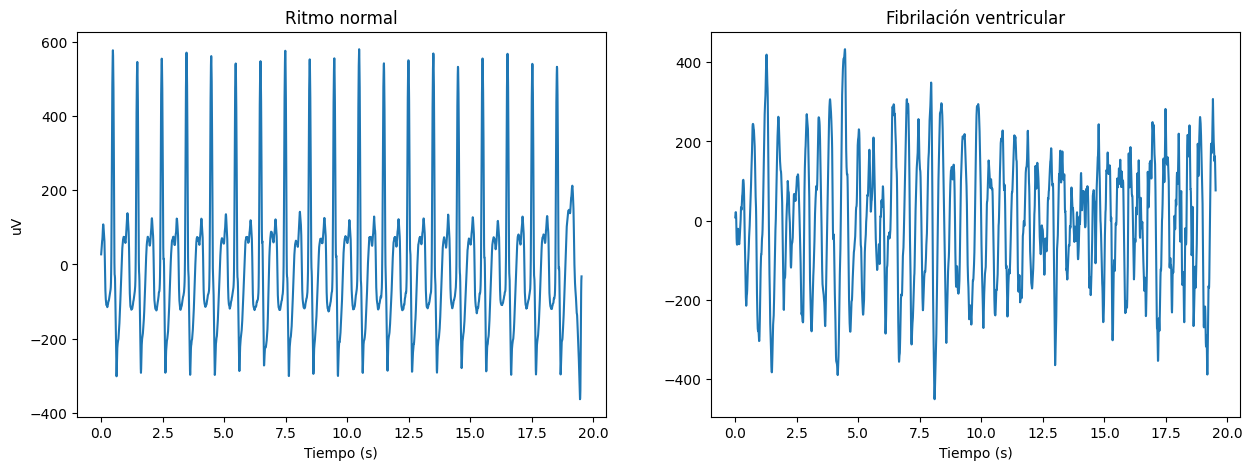

In [7]:
tECG = np.arange(0, ecg1.size/fs, 1/fs)
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(tECG,ecg1)
plt.xlabel('Tiempo (s)')
plt.ylabel('uV')
plt.title('Ritmo normal')
plt.subplot(1,2,2)
plt.plot(tECG,ecg2)
plt.xlabel('Tiempo (s)')
plt.title('Fibrilación ventricular')

Ahora vamos a trabajar con una función que nos permite calcular las características en la frecuencia:

In [8]:
def frequencyFeatures(signal,fs):
  percentiles=[0.1, 0.5, 0.9, 0.95] #definir los percentiles a calcular
  f, Pxx_den = welch(signal, fs, nperseg=1024)
  Pxx_cum=np.cumsum(Pxx_den)/np.sum(Pxx_den); #se calcula la frecuencia acumulada
  indexPercentiles=np.zeros([np.size(percentiles)])
  j=0
  for i in percentiles:
    indexPercentiles[j]=np.argmin(abs(Pxx_cum-i)) #se encuentra el indice de los percentiles
    j+=1
  FrequencyPercentiles=f[indexPercentiles.astype(int)] #se extraen las frecuencia de los percentiles
  Fmax=f[Pxx_den.argmax()]
  limiteEspectral=FrequencyPercentiles[percentiles.index(0.95)]
  Fmediana=FrequencyPercentiles[percentiles.index(0.5)]
  Bandwidth=FrequencyPercentiles[percentiles.index(0.9)]-FrequencyPercentiles[percentiles.index(0.1)]
  return Fmax, limiteEspectral, Fmediana, Bandwidth




In [9]:
Fmax, limiteEspectral, Fmediana, Bandwidth = frequencyFeatures(ecg1,fs)
print('La frecuencia máxima es',Fmax)
print('El límite espectral es',limiteEspectral)
print('La frecuencia mediana es',Fmediana)
print('El ancho de banda es',Bandwidth)


La frecuencia máxima es 2.0
El límite espectral es 5.875
La frecuencia mediana es 2.0
El ancho de banda es 3.125


Ahora se calculan las características para todas las 60 señales y comparar la distribución en las dos clases (ritmos sinusal y fibrilación ventricular)

In [10]:
caracteristicas=np.zeros([ECG.shape[0],4])
for i in range(ECG.shape[0]):
  x = filtfilt(b, a, ECG[i,:].flatten())
  Fmax, limiteEspectral, Fmediana, Bandwidth = frequencyFeatures(x,fs)
  caracteristicas[i,0]=Fmax
  caracteristicas[i,1]=limiteEspectral
  caracteristicas[i,2]=Fmediana
  caracteristicas[i,3]=Bandwidth




Para comparar las distribuciones se llevan los resultados a un dataframe de Pandas.



In [11]:
import pandas as pd

In [12]:
data=np.concatenate((caracteristicas, labelsECG), axis=1)

In [13]:
dfCaracteristicas = pd.DataFrame(data, columns = ['Fmax','Lespectral','Fmediana','BW','clase'])

In [14]:
dfCaracteristicas.tail()

,Fmax,Lespectral,Fmediana,BW,clase
55,1.500,22.875,1.875,17.875,1.0
56,1.375,18.625,1.250,12.250,1.0
57,2.875,5.375,2.750,1.000,1.0
58,3.250,10.000,3.125,4.375,1.0
59,3.125,11.125,3.000,3.625,1.0


In [15]:
dfCaracteristicas[dfCaracteristicas['clase']==0]['Fmax'].mean()

2.033333333333333

In [16]:
dfCaracteristicas[dfCaracteristicas['clase']==1]['Fmax'].mean()

2.3625

##Análisis exploratorio

In [17]:
import seaborn as sns

<Axes: xlabel='clase', ylabel='BW'>

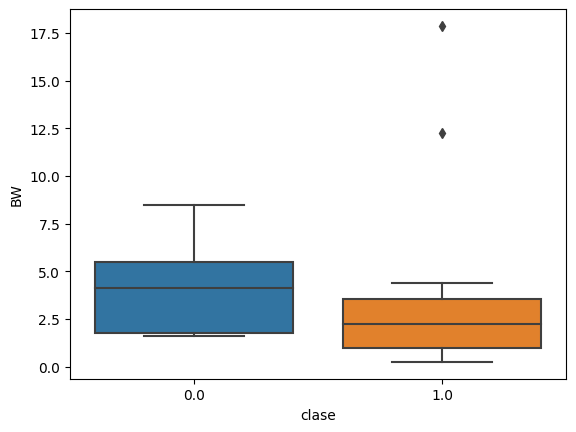

In [18]:
sns.boxplot(data=dfCaracteristicas, y="BW",x='clase')

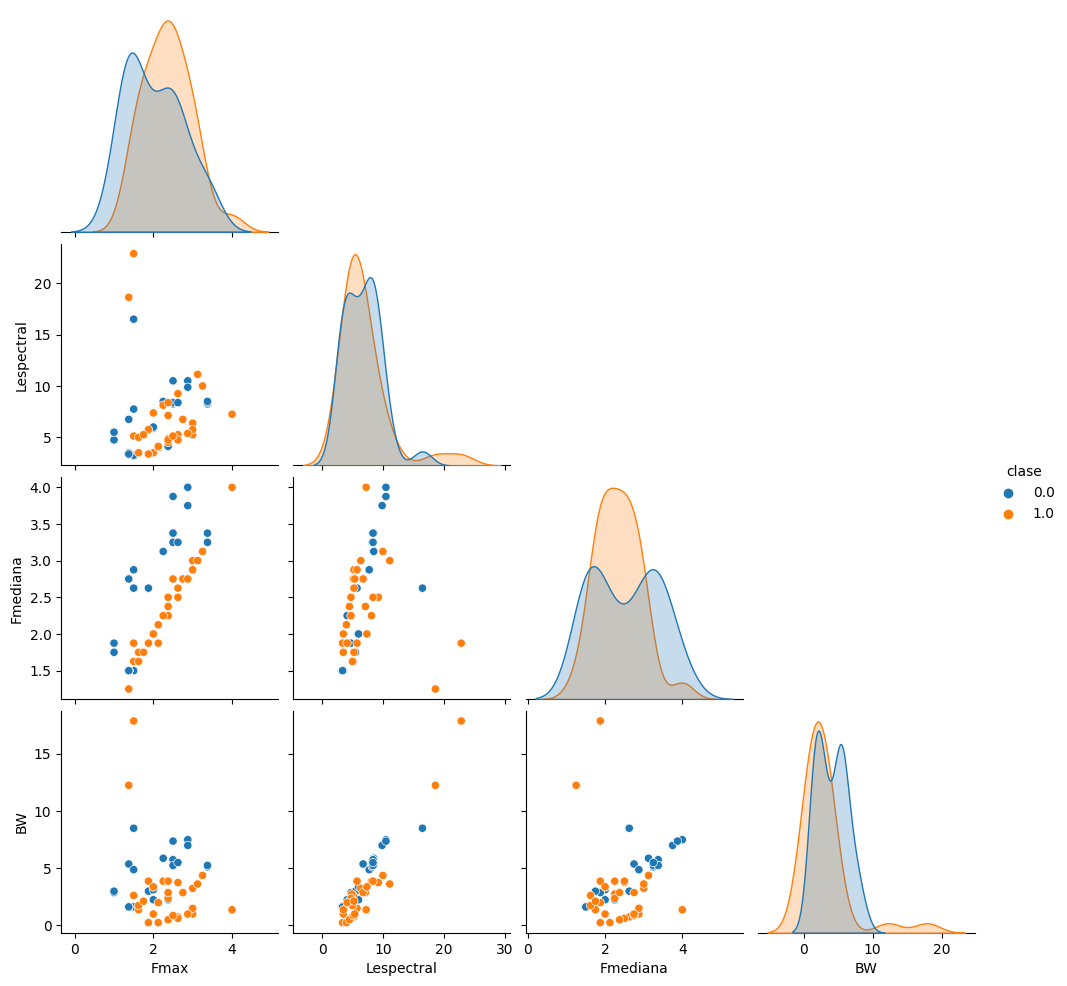

In [19]:
sns.pairplot(dfCaracteristicas, hue="clase", vars=['Fmax','Lespectral','Fmediana','BW'],corner=True)

Para modelos de clasificación se utiliza la libreria sklearn:
https://scikit-learn.org/stable/index.html

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.model_selection import train_test_split
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

##Funciones auxiliares

In [21]:
def confusionMatrix (data,labels,classifier):
  plt.rcParams["figure.figsize"] = (6.4,4.8)
  titles_options = [
      ("Confusion matrix, without normalization", None),
      ("Normalized confusion matrix", "true"),
  ]
  for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_estimator(
          classifier,
          data,
          labels,
          cmap=plt.cm.Blues,
          normalize=normalize,
      )
      disp.ax_.set_title(title)

      #print(title)
      #print(disp.confusion_matrix)

  plt.show()

In [22]:
def results_crossValidation (cv_data):
  results_df = pd.DataFrame(cv_data)
  results_df = results_df.sort_values(by=["rank_test_score"])
  results_df = results_df.set_index(
      results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
  ).rename_axis("kernel")
  return(results_df)

In [23]:
X=caracteristicas[:,0:]
y=labelsECG

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

#Modelo de regresión logística

In [25]:
logreg = LogisticRegression(C=1e1, solver='lbfgs',max_iter=10000)  #se crea el modelo C tiene que ver con la tasa de aprendizaje


In [26]:
params = {
    'C':np.logspace(-3,5,9),
    'max_iter': [500, 1000, 10000],}
search = GridSearchCV(logreg, params, cv=3)
search.fit(X_train_scaled, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best parameter (CV score=0.708):
{'C': 100.0, 'max_iter': 500}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [27]:
sfs1 = SFS(search,
           k_features=4,
           forward=True,
           floating=False,
           #verbose=2,
           scoring='f1',
           cv=5)

sfs1 = sfs1.fit(X_train_scaled,y_train)

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expe

In [28]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

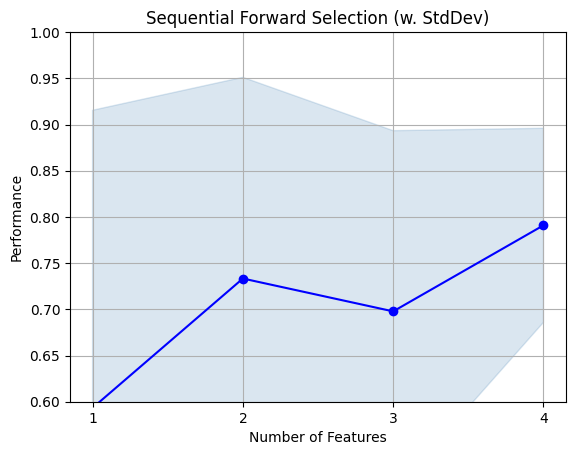

In [29]:
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.6, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [30]:
sfs1.k_feature_idx_

(0, 1, 2, 3)

In [31]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.5, 0.8333333333333333, 0.8333333333333333, ...",0.593333,"(3,)",0.413962,0.322077,0.161038
2,"(1, 3)","[0.888888888888889, 0.888888888888889, 0.33333...",0.733333,"(1, 3)",0.27985,0.217732,0.108866
3,"(0, 1, 3)","[0.888888888888889, 0.8000000000000002, 0.3333...",0.697778,"(0, 1, 3)",0.251346,0.195556,0.097778
4,"(0, 1, 2, 3)","[1.0, 0.7272727272727272, 0.7499999999999999, ...",0.790909,"(0, 1, 2, 3)",0.135005,0.105038,0.052519


In [32]:
y_pred=search.predict(X_test_scaled)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.75      1.00      0.86         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12



#Modelo random forest

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [35]:
# Crea el modelo Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrena el modelo en el conjunto de entrenamiento
random_forest_model.fit(X_train_scaled, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = random_forest_model.predict(X_test_scaled)

# Evalúa el modelo
accuracy1 = accuracy_score(y_test, y_pred)
f1_1 =f1_score(y_test, y_pred)
Precision_Score_1=precision_score(y_test, y_pred)
recall_score_1=recall_score(y_test, y_pred)
conf_matrix1 = confusion_matrix(y_test, y_pred)
class_report1 = classification_report(y_test, y_pred)

# Imprime las métricas de evaluación
print("Exactitud (Accuracy1):", accuracy1)
print("F1_1",f1_1)
print("Precision_Score_1",Precision_Score_1)
print("recall_score_1",recall_score_1)
print("\nMatriz de Confusión:\n", conf_matrix1)
print("\nInforme de Clasificación:\n", class_report1)

Exactitud (Accuracy1): 0.8333333333333334
F1_1 0.8333333333333334
Precision_Score_1 0.8333333333333334
recall_score_1 0.8333333333333334

Matriz de Confusión:
 [[5 1]
 [1 5]]

Informe de Clasificación:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.83      0.83      0.83         6

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12



<ipython-input-35-3ee4f50bd969>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_model.fit(X_train_scaled, y_train)
